# NuSTAR: FPMA fit with gain adjustment and pileup correction

Here we fit one of the NuSTAR focal plane modules (grades 0-4) with a double thermal model.
We adjust for gain shifts and pileup (fit to grades 21-24) which are due to high count rates.
First we run Levenberg-Marquadt on the individual spectra in a clever way,
    and then we fit them simultaneously using a `yaff.fitting.CompositeBayesFitter`.
The fits converge to physically reasonable values,
    and the residuals are a maximum of $\sim3 \sigma$.

### Some background

At high count rates, the [NuSTAR](https://nustar.caltech.edu/) telescope begins to experience issues.
It's an astrophysics telescope,
    not a solar telescope.

A commonly known issue is that of a gain shift.
It's hypothesized that this is due to an elevated baseline because the electronic pulses from X-ray hits
    don't entirely return to baseline before another hit occurs.
We adjust for the gain shift by shifting the count energy bins.
The proper way to do this would be to recalibrate the response matrices,
    however this is time consuming and very technical to do.
To "just get an answer,"
    applying a gain shift is an adequate stopgap.

Another issue is that of pileup.
We fit an [exponentially modified Gaussian](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution)
    model to the "pileup grades" (21 through 24),
    and add that model on top of the double thermal model.

## First: import some packages, load the data, and define the models
The data used in this notebook may be found [here](https://drive.google.com/file/d/1Ksa-wFIZF2jOL8FuLf6vK9u73ISzaf-Z)

In [1]:
import os
# Make the thermal emission matrix multiplications
# use fewer CPU cores.
# This can speed up MCMC, ironically.
os.environ["OMP_NUM_THREADS"] = "4"

import astropy.units as u
from astropy.io import fits
import sunkit_spex.legacy.fitting.instruments as instr
import matplotlib.pyplot as plt
import numpy as np
import pprint

from yaff import fitting
from yaff import plotting as yap
%matplotlib inline
plt.style.use('nice.mplstyle')

# Silence division errors
_ = np.seterr(divide='ignore', invalid='ignore')

In [2]:
def data_pack_from_files(prefix) -> fitting.DataPacket:
    '''Load NuSTAR pha, arf, and rmf files into fitting.DataPackets.
    Uses legacy loaders from sunkit_spex to decompress the RMF file,
    in particular.
    '''
    flatten = lambda a: np.concatenate((a[:, 0], [a[-1, -1]]))
    data = instr.NustarLoader(
        pha_file=f'{prefix}.pha',
        arf_file=f'{prefix}.arf',
        rmf_file=f'{prefix}.rmf',
    )._loaded_spec_data

    res = data['srm'].T << (u.cm**2 * u.ct / u.ph)

    ct_edges = flatten(data['count_channel_bins']) << u.keV
    ph_edges = flatten(data['photon_channel_bins']) << u.keV

    cts = data['counts'] << u.ct
    exposure = data['effective_exposure'] << u.s

    return fitting.DataPacket(
        counts=cts,
        counts_error=np.sqrt(cts.value) << u.ct,
        background_counts=0 * cts,
        background_counts_error=0 * cts,
        effective_exposure=exposure,
        count_energy_edges=ct_edges,
        photon_energy_edges=ph_edges,
        response_matrix=res
    )

In [3]:
# Load in the different grade data products:
# grades 0-4 are the usable flare data
# grades 21-24 are associated with pileup events
flare_data = data_pack_from_files('fpmA_g0-4')
pileup_data = data_pack_from_files('fpmA_g21-24_sr')

/home/william/dev/yaff/yaff/fitting.py:95: UserWarning: 
Your response matrix is square.
Make sure it is oriented properly, C = (SRM @ P).
Can't tell from photon vs count edge shapes
  warnings.warn(


Now we define two models:
- The pileup model, which is an exponentially-modified Gaussian
- A two-thermal model, which just calls the thermal model twice.

The parameter names are defined by the keys used in the model function bodies.
So for the pileup model,
    we have `mu, sigma, lambda, flux_scale`,
    and for the two thermal model,
    we have two temperatures `ta, tb` and two emission measures `ema, emb`.

In [4]:
from yaff import common_models as cm
from scipy.special import erfc

second_prefac = (1 / np.sqrt(2))
def pileup_model(args: cm.ArgsT) -> np.ndarray:
    '''The pileup model is an exponentially-modified Gaussian,
    which has been scaled into photon flux units by the `flux_scale` parameter.'''
    edges: np.ndarray = args['photon_energy_edges']
    mids = (edges[:-1] + np.diff(edges)/2)

    params: dict[str, fitting.Parameter] = args['parameters']
    m = params['mu'].as_quantity().to_value(u.keV)
    s = params['sigma'].as_quantity().to_value(u.keV)
    l = params['lambda'].as_quantity().to_value(1 / u.keV)

    first_expon = np.exp(
        (l * m) + (l * s)**2 / 2 - (l * mids)
    )
    second_expon = erfc(
        second_prefac * 
        ((m / s) + (l * s) - (mids / s))
    )

    fs = params['flux_scale'].as_quantity().to_value(u.ph / u.cm**2 / u.s)
    return fs * (l / 2) * first_expon * second_expon


def two_thermal(args: cm.ArgsT) -> np.ndarray:
    '''The two-thermal model evaluates...the single thermal model twice!'''
    params = args['parameters']

    a = cm.thermal({
        'photon_energy_edges': args['photon_energy_edges'],
        'parameters': {'temperature': params['ta'], 'emission_measure': params['ema']}
    })
    b = cm.thermal({
        'photon_energy_edges': args['photon_energy_edges'],
        'parameters': {'temperature': params['tb'], 'emission_measure': params['emb']}
    })
    return a + b


def full_model(args: cm.ArgsT) -> np.ndarray:
    # The factor of 5/4 comes from reasoning regarding the pileup grades.
    return two_thermal(args) + (5 / 4) * pileup_model(args)

In [5]:
from yaff import common_likelihoods

# make these shorter
p = fitting.Parameter
b = fitting.simple_bounds

# The flare is made up of two isothermal plasmas
flare_params = {
    'ta': p(10 << u.MK, False),
    'tb': p(5 << u.MK, False),
    'ema': p(1 << (1e46 * u.cm**-3), False),
    'emb': p(0.1 << (1e46 * u.cm**-3), False),
}

# We restrict the temperatures of the plasmas to something cool
# and something hot.
# The emission measures are pretty much unbounded.
flare_priors = {
    'ta': b(5, 20),
    'tb': b(2, 10),
    'ema': b(1e-4, 1e3),
    'emb': b(1e-4, 1e3),
}

# The pileup model takes a few parameters which change its shape.
# The units are determined by its functional form
pileup_params = {
    'mu': p(3 << u.keV, False),
    'sigma': p(1 << u.keV, False),
    'lambda': p(2 << (1 / u.keV), False),
    'flux_scale': p(1e1 << u.ph / u.cm**2 / u.s, False)
}
pileup_priors = {
    'mu': b(-10, 10),
    'sigma': b(-10, 10),
    'lambda': b(0, 10),
    'flux_scale': b(0, 1e10),
}

### Fitting: order of attack

Now that the model parameters and priors have all been defined explicitly, we can start to set up the fitters.

The approach is as follows:
- One fitter is for the flare data
- One fitter is for the pileup data.

During the actual fitting process, we follow a few steps to achieve a robust result.
1. Fit the pileup with a gain slope of 1
2. Add the pileup as a frozen model to the flare data, and fit the gain
3. Refit pileup with the adjusted gain
4. Refit the flare data
5. Run MCMC on the joint models

In [6]:
# First, construct the flare fitter with its own Poisson likelihood
fit_range = (flare_data.count_energy_mids > 2.5) & (flare_data.count_energy_mids < 10)
likelihood = common_likelihoods.poisson_factory(fit_range)

flare_fitter = fitting.BayesFitterWithGain(
    data=flare_data,
    model_function=full_model,
    parameters=(flare_params | pileup_params),
    log_priors=(flare_priors | pileup_priors),
    log_likelihood=likelihood
)

# Next, construct the pileup fitter, which fits a different range of energies
pileup_fit_range = (flare_data.count_energy_mids > 3)
pileup_likelihood = common_likelihoods.poisson_factory(pileup_fit_range)

pileup_fitter = fitting.BayesFitterWithGain(
    data=pileup_data,
    model_function=pileup_model,
    parameters=pileup_params,
    log_priors=pileup_priors,
    log_likelihood=pileup_likelihood
)

/home/william/dev/yaff/yaff/fitting.py:559: UserWarning: 
Gain slope and offset parameters/priors added to the parameter/prior ODicts.
  warnings.warn("\nGain slope and offset parameters/priors added to the parameter/prior ODicts.")


In [7]:
# First step: fit only the pileup data
fitting.levenberg_minimize(pileup_fitter, restriction=pileup_fit_range)

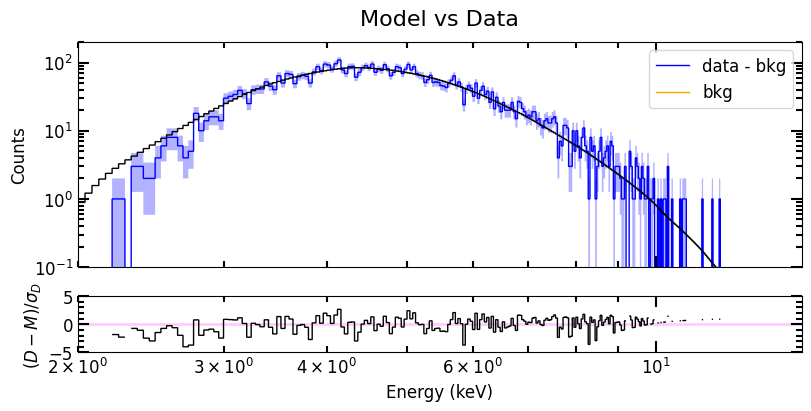

In [8]:
# Check the pileup fit; should look quite good
ret = yap.plot_data_model(pileup_fitter)
ret['data_ax'].set(xlim=(2, 15), ylim=(1e-1, 2e2))
plt.show()

In [9]:
# Step 2: fit the flare using a free gain,
# with fixed pileup parameters

# Update all but the gain parameters in the flare_fitter to the
# fitted pileup parameters, and freeze them
for (k, p) in pileup_fitter.parameters.items():
    if 'gain' in k:
        continue

    flare_fitter.parameters[k].value = p.value
    flare_fitter.parameters[k].frozen = True

# Now we focus on the gain correction.
# For NuSTAR, generally the gain_offset is set to zero (frozen),
# while the slope is allowed to vary to numbers close to 1.

flare_fitter.parameters['gain_offset'].frozen = True
flare_fitter.parameters['gain_slope'].frozen = False
flare_fitter.parameters['gain_slope'].value = 1.
flare_fitter.log_priors['gain_slope'] = fitting.simple_bounds(0.95, 1.05)

In [10]:
# Now, minimize the flare fitter to get a better estimate of the gain slope,
# including the constant pileup portion.
fitting.levenberg_minimize(flare_fitter, restriction=fit_range)

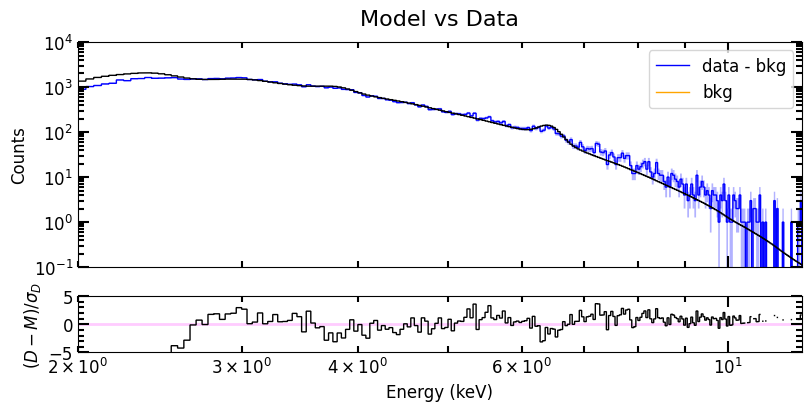

In [11]:
# The fit should look OK at this point, and the gain is different from 1
ret = yap.plot_data_model(flare_fitter)
ret['data_ax'].set(xlim=(2, 12), ylim=(0.1, 1e4))
plt.show()

In [12]:
# Step 3: re-fit the pileup with the gain slope we found earlier,
# leaving it frozen in the pileup_fitter
pileup_fitter.parameters['gain_slope'].value = flare_fitter.parameters['gain_slope'].value
fitting.levenberg_minimize(pileup_fitter, restriction=pileup_fit_range)

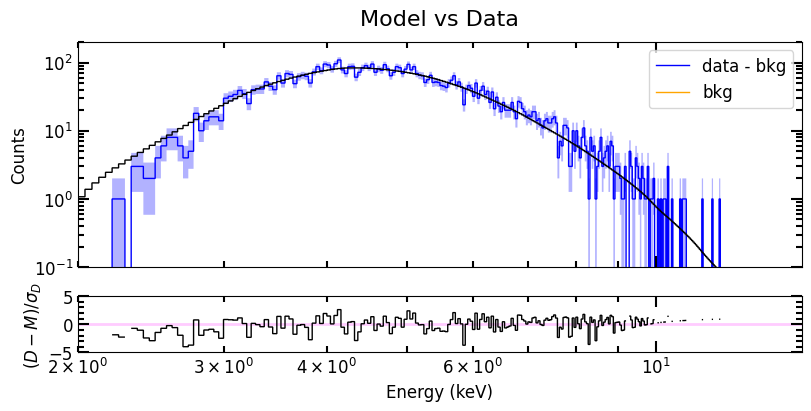

OrderedDict([('mu', Parameter[3.49e+00, keV, frozen=False]),
             ('sigma', Parameter[8.68e-01, keV, frozen=False]),
             ('lambda', Parameter[9.75e-01, 1 / keV, frozen=False]),
             ('flux_scale', Parameter[3.95e+01, ph / (s cm2), frozen=False]),
             ('gain_slope', Parameter[9.79e-01, , frozen=True]),
             ('gain_offset', Parameter[0.00e+00, keV, frozen=True])])

In [13]:
# The gain fit should look good once again, but the parameters likely changed some
ret = yap.plot_data_model(pileup_fitter)
ret['data_ax'].set(xlim=(2, 15), ylim=(1e-1, 2e2))
plt.show()
pileup_fitter.parameters

In [14]:
# Step 4: refit flare data with the gain-adjusted pileup parameters.
# Update them in the flare_fitter and leave them frozen for the fit.
for (k, p) in pileup_fitter.parameters.items():
    if 'gain' in k:
        continue

    flare_fitter.parameters[k].value = p.value
    flare_fitter.parameters[k].frozen = True

In [15]:
fitting.levenberg_minimize(flare_fitter, restriction=fit_range)

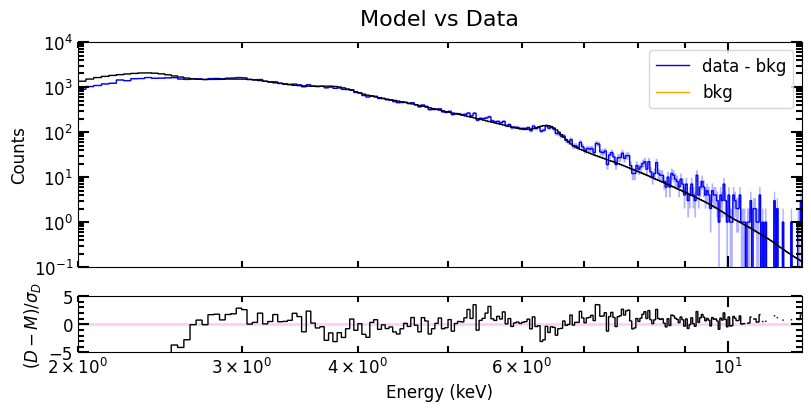

In [16]:
# The fit should look OK better than before, but not by much.
ret = yap.plot_data_model(flare_fitter)
ret['data_ax'].set(xlim=(2, 12), ylim=(0.1, 1e4))
plt.show()

In [17]:
# Freeze the gain at this point--we don't want to fit it with MCMC,
# as it can really go off the rails.
# Feel free to try it, but be advised that it might not work very well.
flare_fitter.parameters['gain_slope'].frozen = True
pileup_fitter.parameters['gain_slope'].value = flare_fitter.parameters['gain_slope'].value

In [18]:
# Step 5: fit both the pileup and flare models simultaneously using MCMC
composite = fitting.CompositeBayesFitter(
    [flare_fitter, pileup_fitter],
    # The only shared parameters are the pileup parameters.
    # Technically the gain is being applied to both models,
    # but we've already frozen and set the gain slope individually.
    # So here we just share the pileup parameters.
    shared_param_names=['mu', 'sigma', 'lambda', 'flux_scale']
)

# Make all shared params free at this point
for k in composite.parameters['shared']:
    composite.parameters['shared'][k].frozen = False


# We need to be careful with the parameters at this point.
# No gain parameters should be free; doesn't matter if they are shared, but the slopes should match.
# The flare parameters (emission measure, temp) should all be free.
# The shared parameters should all be free (not frozen).
pprint.pprint(composite.parameters)

{'fitter 0': {'ema': Parameter[8.53e-01, 1e+46 / cm3, frozen=False],
              'emb': Parameter[1.98e+00, 1e+46 / cm3, frozen=False],
              'gain_offset': Parameter[0.00e+00, keV, frozen=True],
              'gain_slope': Parameter[9.78e-01, , frozen=True],
              'ta': Parameter[1.08e+01, MK, frozen=False],
              'tb': Parameter[6.16e+00, MK, frozen=False]},
 'fitter 1': {'gain_offset': Parameter[0.00e+00, keV, frozen=True],
              'gain_slope': Parameter[9.78e-01, , frozen=True]},
 'shared': OrderedDict([('mu', Parameter[3.49e+00, keV, frozen=False]),
                        ('sigma', Parameter[8.68e-01, keV, frozen=False]),
                        ('lambda', Parameter[9.75e-01, 1 / keV, frozen=False]),
                        ('flux_scale',
                         Parameter[3.95e+01, ph / (s cm2), frozen=False])])}


In [19]:
# Now, run the MCMC analysis. This will probably take a while...!
composite.run_emcee({'nwalkers': 32}, {'nsteps': 1000})

100%|██████████| 1000/1000 [11:50<00:00,  1.41it/s]


In [20]:
# There are so many parameters here that plotting them all on a figure
# would be difficult.
# Instead we export a .png file for viewing externally.
plt.style.use('nice.mplstyle')
fig = plt.figure(figsize=(10, 40))
yap.plot_parameter_chains(
    composite,
    composite.free_param_names,
    composite.free_parameters,
    fig=fig
)
fig.savefig('nustar-pileup-params.png', dpi=300)
plt.close(fig)

In [21]:
# Same goes with the corner plot---too many parameters to fit into a Jupyter window.
# Export the plot to a .PNG and see what's up later on.
fig = plt.figure(figsize=(20, 20), layout='tight')
yap.corner_plot(composite, burnin=(50 * composite.emcee_sampler.nwalkers), fig=fig)
fig.savefig('nustar-composite-corner.png', dpi=300)
plt.close(fig)

The parameter plots show that the fit parameters have settled to stable values.
After burning-in the data, we can put uncertainties on the fit parameters.

In the corner plots, we see the typical correlations between temperature and emission measure. We also see that the fit has converged and the posteriors are shaped nicely.

### A final step: overplotting some models on the data

We need to do some shenanigans to plot the models on the data (at least, while this portion of the package is further developed).

Currently,
    the `CompositeBayesFitter` does not have a method to generate model samples easily.
Conveniently,
    the `flare_fitter` has the same parameters as the composite one,
    so we can just update the parameters by name from the composite fitter to generate different models.

In [22]:
# From the composite fit (pileup + flare), generate some model samples and overplot them on the data
burn = (50 * composite.emcee_sampler.nwalkers)
chain = composite.emcee_sampler.flatchain[burn:]

num_samples = 100
indices = np.random.randint(0, chain.shape[0], num_samples)
models = list()
for i in indices:
    pvec = chain[i]
    for (n, v) in zip(composite.free_param_names, pvec):
        flare_fitter.parameters[n].value = v
    models.append(flare_fitter.eval_model())

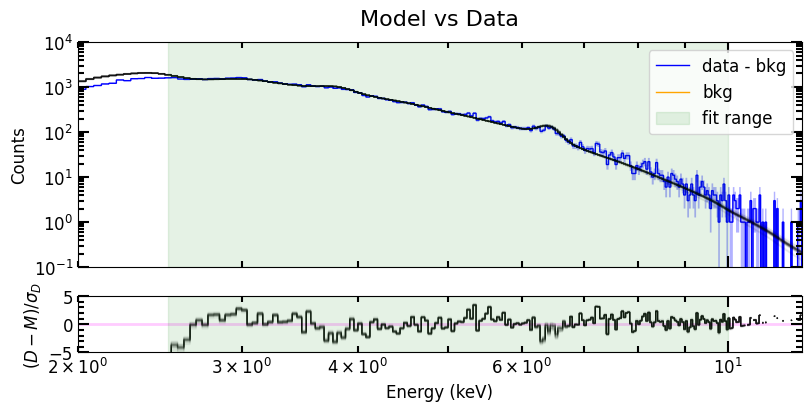

In [23]:
# Finally, plot the model samples on the data, and mark the fitting range we used
fig = plt.figure()
ret = yap.plot_data_model(flare_fitter, model_samples=models, fig=fig)
ret['data_ax'].axvspan(2.5, 10, color='green', alpha=0.1, label='fit range')
ret['error_ax'].axvspan(2.5, 10, color='green', alpha=0.1)
ret['data_ax'].set(xlim=(2, 12), ylim=(0.1, 1e4))
ret['data_ax'].legend()
plt.show()

## There are still some systematics present in the residuals. Pileup is hard!